/home/users/tlavigne/environments/jupyter_env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


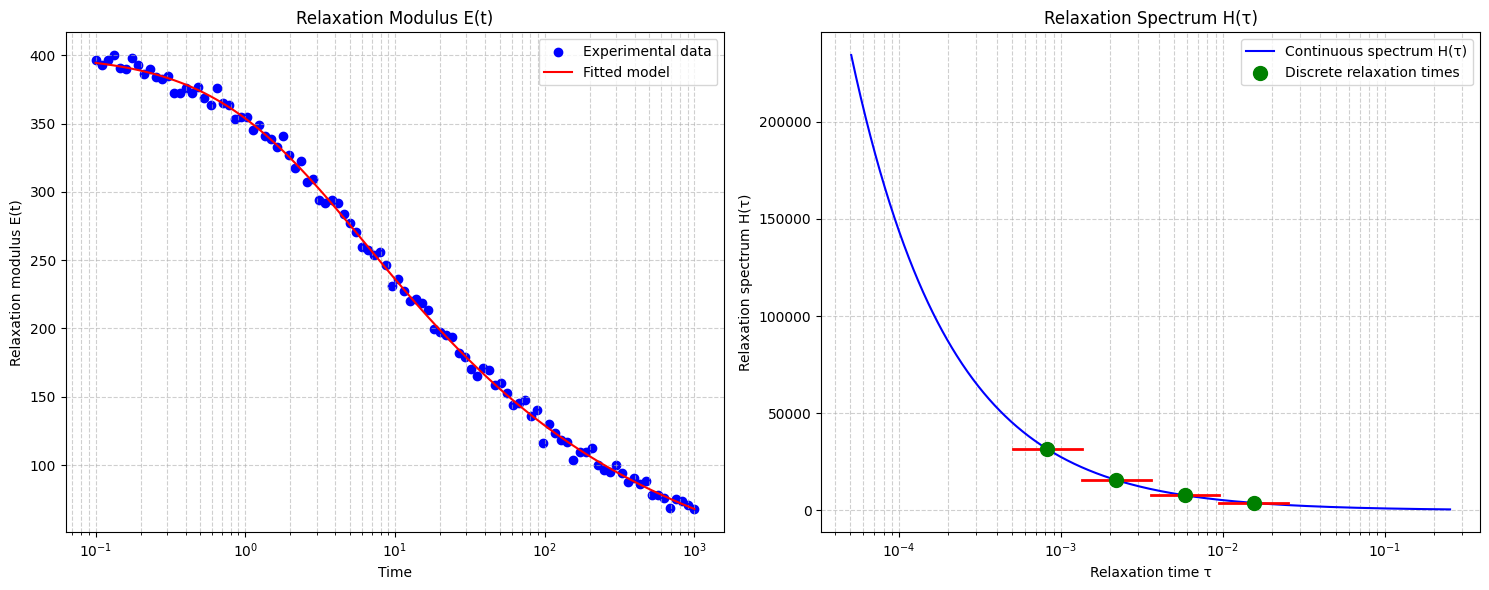

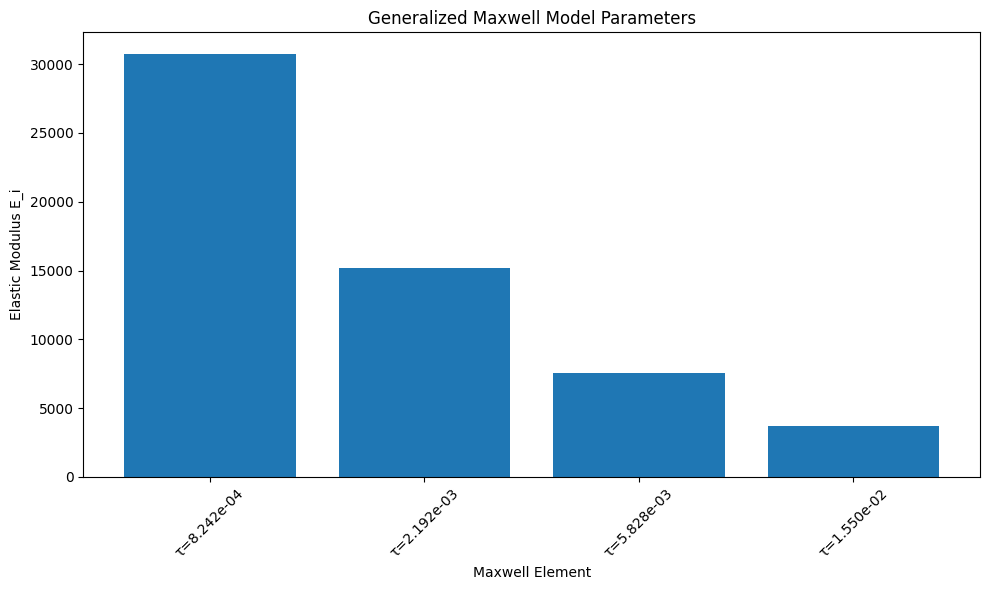

Continuous Model Parameters:
  E0: 0.0
  Eg: 400.4525161213046
  beta: 0.2808085553048693
  t0: 1.8000170096460952

Generalized Maxwell Model Parameters:
  Element 1: E = 30769.43, τ = 8.2425e-04
  Element 2: E = 15216.62, τ = 2.1918e-03
  Element 3: E = 7515.71, τ = 5.8283e-03
  Element 4: E = 3699.69, τ = 1.5498e-02

Residual R = 0.2044


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gamma
import pandas as pd

class RelaxationExperiments:
    """
    Implementation of methods from the paper for identifying generalized Maxwell model
    parameters from relaxation experiments data.
    """
    
    def __init__(self):
        self.E0 = None  # Long-time relaxation modulus
        self.Eg = None  # Short-time relaxation modulus
        self.beta = None  # Beta parameter
        self.t0 = None  # Characteristic time
        self.n_elements = None  # Number of Maxwell elements
        
    def relaxation_modulus(self, t, E0, Eg, beta, t0):
        """
        Calculate the relaxation modulus E(t) using equation (28) from the paper.
        
        E(t) = E0 + (Eg - E0) / (1 + t/t0)^beta
        
        Parameters:
        - t: time points
        - E0: Long-time relaxation modulus
        - Eg: Short-time relaxation modulus
        - beta: Model parameter
        - t0: Characteristic time
        
        Returns:
        - E(t): Relaxation modulus values
        """
        return E0 + (Eg - E0) / (1 + t/t0)**beta
    
    def continuous_spectrum_H(self, tau, Eg, E0, beta, t0):
        """
        Calculate the continuous relaxation spectrum H(τ) using eq. (31)
        
        H(τ) = (Eg - E0) / Γ(β) * (τ/t0)^(-1) * e^(-τ/t0)
        
        Parameters:
        - tau: Relaxation time points
        - Eg: Short-time relaxation modulus
        - E0: Long-time relaxation modulus
        - beta: Model parameter
        - t0: Characteristic time
        
        Returns:
        - H(tau): Continuous relaxation spectrum
        """
        return (Eg - E0) / gamma(beta) * (tau/t0)**(beta-1) * np.exp(-tau/t0)
    
    def unit_box_function(self, tau, tau_i, tau_ip1):
        """
        Unit box function defined in the paper, eq. (33)
        Returns 1 if tau_i ≤ tau < tau_ip1, 0 otherwise
        """
        return 1 if (tau_i <= tau < tau_ip1) else 0
    
    def staircase_function(self, tau, tau_values, H_values):
        """
        Staircase function S(τ) representing the generalized Maxwell model with n elements
        S(τ) = sum_i H_i * U_[τ_i, τ_(i+1)](τ)
        
        Parameters:
        - tau: Relaxation time point
        - tau_values: Array of relaxation times
        - H_values: Array of H values corresponding to tau_values
        
        Returns:
        - S(tau): Staircase function value at tau
        """
        result = 0
        for i in range(len(tau_values) - 1):
            result += H_values[i] * self.unit_box_function(tau, tau_values[i], tau_values[i+1])
        return result
    
    def calculate_R_residual(self, tau_values, H_spectrum, H_values):
        """
        Calculate the residual R using equation (34) from the paper:
        
        R = ||∫(H(τ) - S(τ))^2 dτ|| / ||∫H(τ)^2 dτ||
        
        This measures the relative distance between H(τ) and S(τ)
        
        Parameters:
        - tau_values: Array of τ values for integration
        - H_spectrum: Function that calculates H(τ) at given τ
        - H_values: Array of H values for the staircase function
        
        Returns:
        - R: Residual value
        """
        # Numerical integration using trapezoidal rule
        tau_extended = np.logspace(np.log10(min(tau_values)), np.log10(max(tau_values)), 1000)
        
        # Calculate H(τ) and S(τ) for integration points
        H_tau = np.array([H_spectrum(tau) for tau in tau_extended])
        S_tau = np.zeros_like(H_tau)
        
        for i, tau in enumerate(tau_extended):
            for j in range(len(tau_values) - 1):
                if tau_values[j] <= tau < tau_values[j+1]:
                    S_tau[i] = H_values[j]
                    break
        
        # Calculate squared differences for integration
        diff_squared = (H_tau - S_tau)**2
        H_squared = H_tau**2
        
        # Trapezoidal integration
        diff_integral = np.trapz(diff_squared, tau_extended)
        H_integral = np.trapz(H_squared, tau_extended)
        
        # Calculate R residual
        R = np.sqrt(diff_integral / H_integral)
        
        return R
    
    def fit_continuous_model(self, times, modulus_values):
        """
        Fit the continuous relaxation model (eq. 28) to experimental data
        to determine E0, Eg, beta, and t0 parameters.
        
        Parameters:
        - times: Experimental time points
        - modulus_values: Experimental relaxation modulus values
        
        Returns:
        - params: Dictionary with fitted parameters
        """
        # Initial guess for parameters
        # E0: min value of modulus (long-time limit)
        # Eg: max value of modulus (short-time limit)
        # beta and t0: reasonable starting values
        initial_params = [
            min(modulus_values),  # E0
            max(modulus_values),  # Eg
            0.5,  # beta
            np.median(times)  # t0
        ]
        
        # Define objective function to minimize (sum of squared errors)
        def objective(params):
            E0, Eg, beta, t0 = params
            predicted = self.relaxation_modulus(times, E0, Eg, beta, t0)
            return np.sum((predicted - modulus_values)**2)
        
        # Parameter bounds
        bounds = [
            (0, min(modulus_values)*1.1),  # E0 > 0 and near min value
            (max(modulus_values)*0.9, max(modulus_values)*1.5),  # Eg near max value
            (0.01, 1.0),  # 0 < beta < 1
            (min(times), max(times))  # t0 within time range
        ]
        
        # Perform optimization
        result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')
        
        # Extract fitted parameters
        E0, Eg, beta, t0 = result.x
        
        self.E0 = E0
        self.Eg = Eg
        self.beta = beta
        self.t0 = t0
        
        return {
            'E0': E0,
            'Eg': Eg,
            'beta': beta,
            't0': t0
        }
    
    def determine_optimal_relaxation_times(self, n_elements, c1=0.001, c2=0.05):
        """
        Determine the optimal distribution of relaxation times based on the R method.
        Uses logarithmic equidistant distribution of relaxation times based on the 
        continuous spectrum support.
        
        Parameters:
        - n_elements: Number of Maxwell elements
        - c1: Lower bound parameter (default 0.001 as mentioned in paper)
        - c2: Upper bound parameter (default 0.05 as mentioned in paper)
        
        Returns:
        - tau_values: Array of optimized relaxation times
        - H_values: Array of corresponding H values
        """
        # Ensure continuous model parameters are fitted
        if any(param is None for param in [self.E0, self.Eg, self.beta, self.t0]):
            raise ValueError("Continuous model parameters must be fitted first")
        
        # Find tau_max (peak of H(τ))
        tau_max = self.beta * self.t0
        
        # Define support bounds
        tau_1 = c1 * tau_max
        tau_n = c2 * tau_max
        
        # Create logarithmically equidistant relaxation times
        tau_values = np.logspace(np.log10(tau_1), np.log10(tau_n), n_elements + 1)
        
        # Calculate H values at the geometric average of consecutive tau intervals
        H_values = np.zeros(n_elements)
        for i in range(n_elements):
            tau_avg = np.sqrt(tau_values[i] * tau_values[i+1])  # Geometric average
            H_values[i] = self.continuous_spectrum_H(tau_avg, self.Eg, self.E0, self.beta, self.t0)
        
        self.n_elements = n_elements
        
        return tau_values, H_values
    
    def optimize_relaxation_times(self, n_elements, c1=0.001, c2=0.05, max_iterations=100):
        """
        Optimize the distribution of relaxation times by minimizing the R residual.
        This implements the R method from the paper.
        
        Parameters:
        - n_elements: Number of Maxwell elements
        - c1, c2: Support boundary parameters
        - max_iterations: Maximum iterations for optimization
        
        Returns:
        - optimized_tau: Optimized relaxation times
        - optimized_H: Corresponding H values
        - final_residual: Final R residual value
        """
        # Start with logarithmically equidistant distribution
        tau_values, H_values = self.determine_optimal_relaxation_times(n_elements, c1, c2)
        
        # Define H spectrum function for the continuous model
        def H_spectrum(tau):
            return self.continuous_spectrum_H(tau, self.Eg, self.E0, self.beta, self.t0)
        
        # Define objective function for optimization
        def objective(partition_points):
            # Reconstruct tau_values with tau_1 and tau_n fixed
            new_tau_values = np.zeros(n_elements + 1)
            new_tau_values[0] = tau_values[0]  # tau_1 remains fixed
            new_tau_values[-1] = tau_values[-1]  # tau_n remains fixed
            new_tau_values[1:-1] = partition_points  # Middle points can vary
            
            # Ensure tau values are in ascending order
            if not np.all(np.diff(new_tau_values) > 0):
                return np.inf
            
            # Calculate new H values at geometric averages
            new_H_values = np.zeros(n_elements)
            for i in range(n_elements):
                tau_avg = np.sqrt(new_tau_values[i] * new_tau_values[i+1])
                new_H_values[i] = H_spectrum(tau_avg)
            
            # Calculate residual
            residual = self.calculate_R_residual(new_tau_values, H_spectrum, new_H_values)
            return residual
        
        # Initial values for optimization (middle tau points)
        initial_points = tau_values[1:-1]
        
        # Bounds for optimization
        lower_bounds = np.ones(n_elements-1) * tau_values[0] * 1.01
        upper_bounds = np.ones(n_elements-1) * tau_values[-1] * 0.99
        bounds = list(zip(lower_bounds, upper_bounds))
        
        # Perform optimization
        result = minimize(
            objective, 
            initial_points, 
            bounds=bounds, 
            method='L-BFGS-B',
            options={'maxiter': max_iterations}
        )
        
        # Reconstruct final tau values and calculate H values
        optimized_tau = np.zeros(n_elements + 1)
        optimized_tau[0] = tau_values[0]
        optimized_tau[-1] = tau_values[-1]
        optimized_tau[1:-1] = result.x
        
        optimized_H = np.zeros(n_elements)
        for i in range(n_elements):
            tau_avg = np.sqrt(optimized_tau[i] * optimized_tau[i+1])
            optimized_H[i] = H_spectrum(tau_avg)
        
        final_residual = result.fun
        
        return optimized_tau, optimized_H, final_residual
    
    def calculate_maxwell_parameters(self, tau_values, H_values):
        """
        Calculate the parameters of the generalized Maxwell model
        
        Parameters:
        - tau_values: Array of relaxation times
        - H_values: Array of corresponding H values
        
        Returns:
        - E_i: Array of elastic moduli
        - tau_i: Array of relaxation times
        """
        # Number of Maxwell elements
        n_elements = len(H_values)
        
        # Calculate E_i values from H_i and tau_i
        E_i = np.zeros(n_elements)
        tau_i = np.zeros(n_elements)
        
        for i in range(n_elements):
            # Calculate geometric average relaxation time
            tau_i[i] = np.sqrt(tau_values[i] * tau_values[i+1])
            
            # Calculate E_i = H_i * ln(tau_{i+1}/tau_i) as per eq. (32)
            E_i[i] = H_values[i] * np.log(tau_values[i+1] / tau_values[i])
        
        return E_i, tau_i
    
    def plot_results(self, times, exp_modulus, fitted_modulus, tau_values, H_values, tau_i, E_i):
        """
        Plot results for visualization:
        1. Experimental data vs fitted continuous model
        2. Continuous relaxation spectrum and discrete approximation
        
        Parameters:
        - times: Experimental time points
        - exp_modulus: Experimental modulus values
        - fitted_modulus: Fitted modulus values from continuous model
        - tau_values: Relaxation time partition points
        - H_values: H values for the staircase function
        - tau_i: Relaxation times for Maxwell elements
        - E_i: Elastic moduli for Maxwell elements
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Relaxation modulus
        ax1.scatter(times, exp_modulus, label='Experimental data', color='blue')
        ax1.plot(times, fitted_modulus, label='Fitted model', color='red')
        ax1.set_xscale('log')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Relaxation modulus E(t)')
        ax1.set_title('Relaxation Modulus E(t)')
        ax1.legend()
        ax1.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Plot 2: Relaxation spectrum
        tau_range = np.logspace(np.log10(min(tau_values)*0.1), np.log10(max(tau_values)*10), 1000)
        H_continuous = np.array([self.continuous_spectrum_H(tau, self.Eg, self.E0, self.beta, self.t0) for tau in tau_range])
        
        ax2.plot(tau_range, H_continuous, label='Continuous spectrum H(τ)', color='blue')
        
        # Plot staircase function
        for i in range(len(tau_values)-1):
            tau_segment = np.linspace(tau_values[i], tau_values[i+1], 10)
            H_segment = np.ones_like(tau_segment) * H_values[i]
            ax2.plot(tau_segment, H_segment, color='red', linewidth=2)
        
        # Mark the discrete relaxation times and moduli
        ax2.scatter(tau_i, H_continuous[np.searchsorted(tau_range, tau_i)], 
                   label='Discrete relaxation times', color='green', s=100, zorder=5)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Relaxation time τ')
        ax2.set_ylabel('Relaxation spectrum H(τ)')
        ax2.set_title('Relaxation Spectrum H(τ)')
        ax2.legend()
        ax2.grid(True, which='both', linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()
        
        # Plot the Maxwell elements
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(E_i)), E_i, tick_label=[f"τ={t:.3e}" for t in tau_i])
        plt.xlabel('Maxwell Element')
        plt.ylabel('Elastic Modulus E_i')
        plt.title('Generalized Maxwell Model Parameters')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def process_experimental_data(self, times, modulus_values, n_elements=4):
        """
        Process experimental data to identify generalized Maxwell model parameters
        
        Parameters:
        - times: Experimental time points
        - modulus_values: Experimental relaxation modulus values
        - n_elements: Number of Maxwell elements to use
        
        Returns:
        - results: Dictionary with model parameters and results
        """
        # 1. Fit continuous model to get E0, Eg, beta, t0
        continuous_params = self.fit_continuous_model(times, modulus_values)
        
        # Calculate fitted modulus values
        fitted_modulus = self.relaxation_modulus(
            times, self.E0, self.Eg, self.beta, self.t0
        )
        
        # 2. Optimize relaxation times using R method
        opt_tau_values, opt_H_values, residual = self.optimize_relaxation_times(n_elements)
        
        # 3. Calculate Maxwell model parameters
        E_i, tau_i = self.calculate_maxwell_parameters(opt_tau_values, opt_H_values)
        
        # 4. Plot results
        self.plot_results(
            times, modulus_values, fitted_modulus, 
            opt_tau_values, opt_H_values, tau_i, E_i
        )
        
        # Return results
        results = {
            'continuous_model': {
                'E0': self.E0,
                'Eg': self.Eg,
                'beta': self.beta,
                't0': self.t0
            },
            'maxwell_model': {
                'E_i': E_i.tolist(),
                'tau_i': tau_i.tolist()
            },
            'residual': residual,
            'n_elements': n_elements
        }
        
        return results

# Example usage with artificial data
def generate_artificial_data():
    """
    Generate artificial data similar to Table 1 in the paper
    """
    # Create sample data similar to the paper's example
    times = np.logspace(-1, 3, 100)  # Time points from 0.1 to 1000
    
    # Parameters based on the paper
    E0 = 8  # Long-time modulus
    Eg = 400  # Short-time modulus
    beta = 0.3  # Beta parameter
    t0 = 2.0  # Characteristic time
    
    # Calculate relaxation modulus
    modulus_values = E0 + (Eg - E0) / (1 + times/t0)**beta
    
    # Add some noise
    np.random.seed(42)
    noise = np.random.normal(0, 5, len(times))
    modulus_values = modulus_values + noise
    
    return times, modulus_values

# Function to load experimental data from CSV
def load_experimental_data(file_path):
    """
    Load experimental data from CSV file
    Expected format: two columns (time, modulus)
    """
    data = pd.read_csv(file_path)
    times = data.iloc[:, 0].values
    modulus_values = data.iloc[:, 1].values
    return times, modulus_values

# Example main function
def main():
    # Create instance of the class
    relaxation = RelaxationExperiments()
    
    # Either generate artificial data or load experimental data
    # times, modulus_values = generate_artificial_data()
    
    # Uncomment to use your own experimental data
    # times, modulus_values = load_experimental_data('your_data.csv')
    
    # For demonstration, use artificial data
    times, modulus_values = generate_artificial_data()
    
    # Process data and identify model parameters
    results = relaxation.process_experimental_data(times, modulus_values, n_elements=4)
    
    # Print results
    print("Continuous Model Parameters:")
    for key, value in results['continuous_model'].items():
        print(f"  {key}: {value}")
    
    print("\nGeneralized Maxwell Model Parameters:")
    for i, (E, tau) in enumerate(zip(results['maxwell_model']['E_i'], results['maxwell_model']['tau_i'])):
        print(f"  Element {i+1}: E = {E:.2f}, τ = {tau:.4e}")
    
    print(f"\nResidual R = {results['residual']:.4f}")

if __name__ == "__main__":
    main()

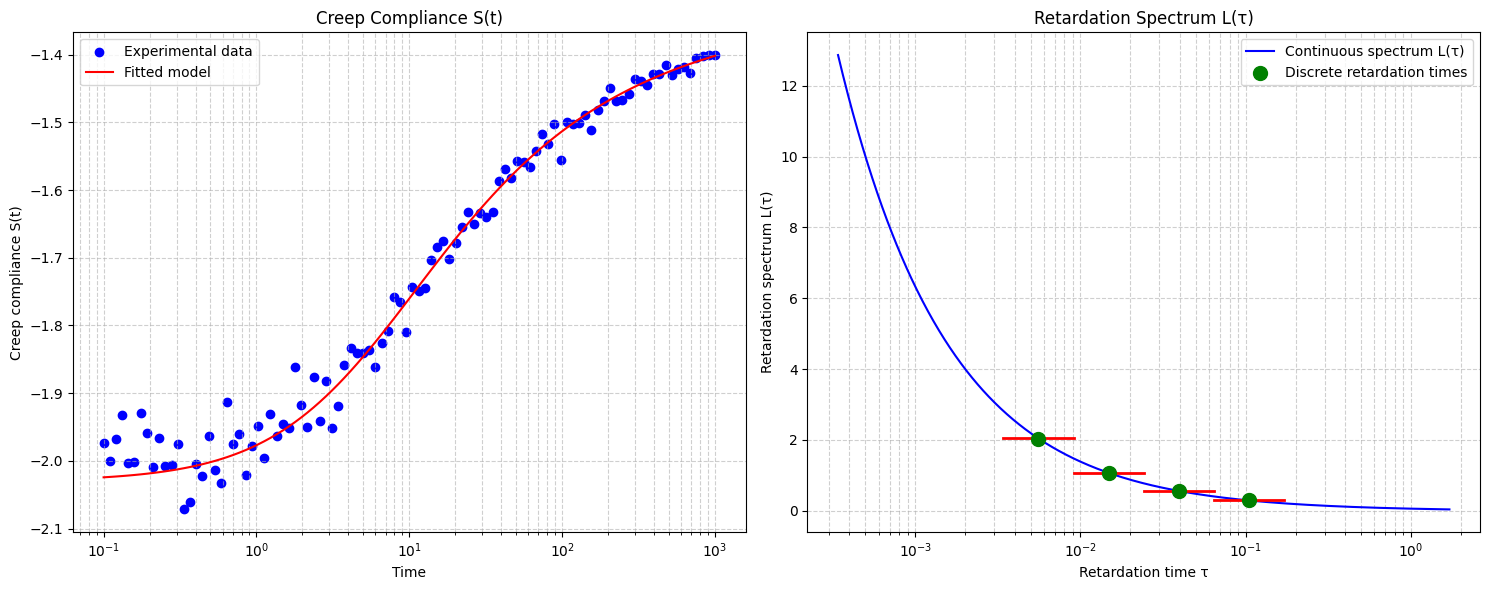

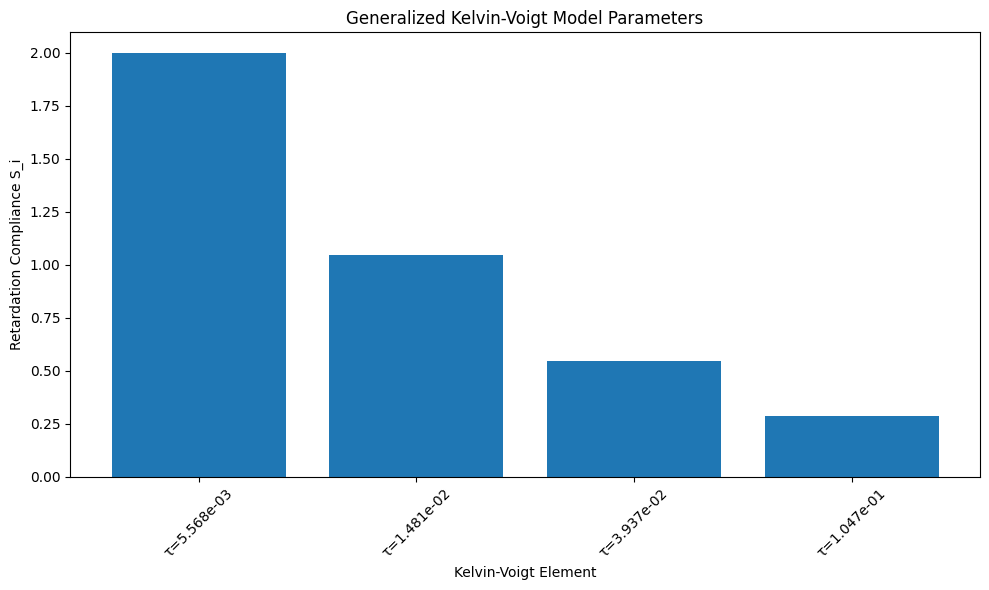

Mean squared error of discrete model: 14.880747
Continuous Model Parameters:
  Sg: 0.009328406161876723
  S_inf: 0.047578535798943625
  beta: 0.340869937719616
  t0: 10.017158368139322

Generalized Kelvin-Voigt Model Parameters:
  Element 1: S = 1.997071, τ = 5.5681e-03
  Element 2: S = 1.047207, τ = 1.4806e-02
  Element 3: S = 0.548286, τ = 3.9372e-02
  Element 4: S = 0.285900, τ = 1.0470e-01

Residual R = 0.1884


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gamma
import pandas as pd

class CreepExperiments:
    """
    Implementation for identifying generalized Kelvin-Voigt model
    parameters from creep experiments data.
    
    The creep compliance function for a generalized Kelvin-Voigt model is:
    S(t) = Sg + sum_i^N S_i * (1 - exp(-t/tau_i))
    
    where:
    - Sg is the instantaneous compliance
    - S_i are the retardation compliances
    - tau_i are the retardation times
    """
    
    def __init__(self):
        self.Sg = None     # Instantaneous compliance
        self.S_inf = None  # Equilibrium (long-term) compliance
        self.beta = None   # Shape parameter (if using continuous spectrum)
        self.t0 = None     # Characteristic time
        self.n_elements = None  # Number of Kelvin-Voigt elements
        
    def creep_compliance_continuous(self, t, Sg, S_inf, beta, t0):
        """
        Calculate the creep compliance S(t) using a continuous spectrum approximation
        similar to the relaxation modulus but adapted for creep:
        
        S(t) = Sg + (S_inf - Sg) * (1 - 1/(1 + t/t0)^beta)
        
        Parameters:
        - t: time points
        - Sg: Instantaneous compliance (short-time)
        - S_inf: Equilibrium compliance (long-time)
        - beta: Shape parameter
        - t0: Characteristic time
        
        Returns:
        - S(t): Creep compliance values
        """
        return Sg + (S_inf - Sg) * (1 - 1/(1 + t/t0)**beta)
    
    def creep_compliance_discrete(self, t, Sg, S_i, tau_i):
        """
        Calculate the creep compliance S(t) using the generalized Kelvin-Voigt model:
        
        S(t) = Sg + sum_i^N S_i * (1 - exp(-t/tau_i))
        
        Parameters:
        - t: time points
        - Sg: Instantaneous compliance
        - S_i: Array of retardation compliances
        - tau_i: Array of retardation times
        
        Returns:
        - S(t): Creep compliance values
        """
        compliance = np.zeros_like(t, dtype=float)
        compliance += Sg  # Add instantaneous compliance
        
        # Add contribution from each Kelvin-Voigt element
        for i in range(len(S_i)):
            compliance += S_i[i] * (1 - np.exp(-t/tau_i[i]))
            
        return compliance
    
    def retardation_spectrum_L(self, tau, Sg, S_inf, beta, t0):
        """
        Calculate the continuous retardation spectrum L(τ) analogous to H(τ)
        for relaxation but adapted for creep.
        
        L(τ) = (S_inf - Sg) / Γ(β) * (τ/t0)^(-1) * e^(-τ/t0)
        
        Parameters:
        - tau: Retardation time points
        - Sg: Instantaneous compliance
        - S_inf: Equilibrium compliance
        - beta: Shape parameter
        - t0: Characteristic time
        
        Returns:
        - L(tau): Continuous retardation spectrum
        """
        return (S_inf - Sg) / gamma(beta) * (tau/t0)**(beta-1) * np.exp(-tau/t0)
    
    def unit_box_function(self, tau, tau_i, tau_ip1):
        """
        Unit box function defined for staircase approximation
        Returns 1 if tau_i ≤ tau < tau_ip1, 0 otherwise
        """
        return 1 if (tau_i <= tau < tau_ip1) else 0
    
    def staircase_function(self, tau, tau_values, L_values):
        """
        Staircase function representing the discrete retardation spectrum
        
        Parameters:
        - tau: Retardation time point
        - tau_values: Array of retardation times boundaries
        - L_values: Array of L values for each interval
        
        Returns:
        - Staircase function value at tau
        """
        result = 0
        for i in range(len(tau_values) - 1):
            result += L_values[i] * self.unit_box_function(tau, tau_values[i], tau_values[i+1])
        return result
    
    def calculate_R_residual(self, tau_values, L_spectrum, L_values):
        """
        Calculate the residual R (similar to relaxation case):
        
        R = ||∫(L(τ) - S(τ))^2 dτ|| / ||∫L(τ)^2 dτ||
        
        This measures the relative distance between L(τ) and its staircase approximation
        
        Parameters:
        - tau_values: Array of τ values for integration
        - L_spectrum: Function that calculates L(τ) at given τ
        - L_values: Array of L values for the staircase function
        
        Returns:
        - R: Residual value
        """
        # Numerical integration using trapezoidal rule
        tau_extended = np.logspace(np.log10(min(tau_values)), np.log10(max(tau_values)), 1000)
        
        # Calculate L(τ) and staircase function for integration points
        L_tau = np.array([L_spectrum(tau) for tau in tau_extended])
        S_tau = np.zeros_like(L_tau)
        
        for i, tau in enumerate(tau_extended):
            for j in range(len(tau_values) - 1):
                if tau_values[j] <= tau < tau_values[j+1]:
                    S_tau[i] = L_values[j]
                    break
        
        # Calculate squared differences for integration
        diff_squared = (L_tau - S_tau)**2
        L_squared = L_tau**2
        
        # Trapezoidal integration
        diff_integral = np.trapz(diff_squared, tau_extended)
        L_integral = np.trapz(L_squared, tau_extended)
        
        # Calculate R residual
        R = np.sqrt(diff_integral / L_integral)
        
        return R
    
    def fit_continuous_model(self, times, compliance_values):
        """
        Fit the continuous creep compliance model to experimental data
        to determine Sg, S_inf, beta, and t0 parameters.
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        
        Returns:
        - params: Dictionary with fitted parameters
        """
        # Initial guess for parameters
        # Sg: min value of compliance (short-time limit)
        # S_inf: max value of compliance (long-time limit)
        # beta and t0: reasonable starting values
        initial_params = [
            min(compliance_values),  # Sg
            max(compliance_values),  # S_inf
            0.5,  # beta
            np.median(times)  # t0
        ]
        
        # Define objective function to minimize (sum of squared errors)
        def objective(params):
            Sg, S_inf, beta, t0 = params
            predicted = self.creep_compliance_continuous(times, Sg, S_inf, beta, t0)
            return np.sum((predicted - compliance_values)**2)
        
        # Parameter bounds
        bounds = [
            (0, min(compliance_values)*1.1),  # Sg > 0 and near min value
            (max(compliance_values)*0.9, max(compliance_values)*1.5),  # S_inf near max value
            (0.01, 1.0),  # 0 < beta < 1
            (min(times), max(times))  # t0 within time range
        ]
        
        # Perform optimization
        result = minimize(objective, initial_params, bounds=bounds, method='L-BFGS-B')
        
        # Extract fitted parameters
        Sg, S_inf, beta, t0 = result.x
        
        self.Sg = Sg
        self.S_inf = S_inf
        self.beta = beta
        self.t0 = t0
        
        return {
            'Sg': Sg,
            'S_inf': S_inf,
            'beta': beta,
            't0': t0
        }
    
    def determine_optimal_retardation_times(self, n_elements, c1=0.001, c2=0.05):
        """
        Determine the optimal distribution of retardation times based on the
        continuous spectrum, similar to the R method for relaxation.
        
        Parameters:
        - n_elements: Number of Kelvin-Voigt elements
        - c1: Lower bound parameter (default 0.001)
        - c2: Upper bound parameter (default 0.05)
        
        Returns:
        - tau_values: Array of retardation time boundaries
        - L_values: Array of corresponding L values
        """
        # Ensure continuous model parameters are fitted
        if any(param is None for param in [self.Sg, self.S_inf, self.beta, self.t0]):
            raise ValueError("Continuous model parameters must be fitted first")
        
        # Find tau_max (peak of L(τ))
        tau_max = self.beta * self.t0
        
        # Define support bounds
        tau_1 = c1 * tau_max
        tau_n = c2 * tau_max
        
        # Create logarithmically equidistant retardation times
        tau_values = np.logspace(np.log10(tau_1), np.log10(tau_n), n_elements + 1)
        
        # Calculate L values at the geometric average of consecutive tau intervals
        L_values = np.zeros(n_elements)
        for i in range(n_elements):
            tau_avg = np.sqrt(tau_values[i] * tau_values[i+1])  # Geometric average
            L_values[i] = self.retardation_spectrum_L(tau_avg, self.Sg, self.S_inf, self.beta, self.t0)
        
        self.n_elements = n_elements
        
        return tau_values, L_values
    
    def optimize_retardation_times(self, n_elements, c1=0.001, c2=0.05, max_iterations=100):
        """
        Optimize the distribution of retardation times by minimizing the R residual.
        
        Parameters:
        - n_elements: Number of Kelvin-Voigt elements
        - c1, c2: Support boundary parameters
        - max_iterations: Maximum iterations for optimization
        
        Returns:
        - optimized_tau: Optimized retardation times
        - optimized_L: Corresponding L values
        - final_residual: Final R residual value
        """
        # Start with logarithmically equidistant distribution
        tau_values, L_values = self.determine_optimal_retardation_times(n_elements, c1, c2)
        
        # Define L spectrum function for the continuous model
        def L_spectrum(tau):
            return self.retardation_spectrum_L(tau, self.Sg, self.S_inf, self.beta, self.t0)
        
        # Define objective function for optimization
        def objective(partition_points):
            # Reconstruct tau_values with tau_1 and tau_n fixed
            new_tau_values = np.zeros(n_elements + 1)
            new_tau_values[0] = tau_values[0]  # tau_1 remains fixed
            new_tau_values[-1] = tau_values[-1]  # tau_n remains fixed
            new_tau_values[1:-1] = partition_points  # Middle points can vary
            
            # Ensure tau values are in ascending order
            if not np.all(np.diff(new_tau_values) > 0):
                return np.inf
            
            # Calculate new L values at geometric averages
            new_L_values = np.zeros(n_elements)
            for i in range(n_elements):
                tau_avg = np.sqrt(new_tau_values[i] * new_tau_values[i+1])
                new_L_values[i] = L_spectrum(tau_avg)
            
            # Calculate residual
            residual = self.calculate_R_residual(new_tau_values, L_spectrum, new_L_values)
            return residual
        
        # Initial values for optimization (middle tau points)
        initial_points = tau_values[1:-1]
        
        # Bounds for optimization
        lower_bounds = np.ones(n_elements-1) * tau_values[0] * 1.01
        upper_bounds = np.ones(n_elements-1) * tau_values[-1] * 0.99
        bounds = list(zip(lower_bounds, upper_bounds))
        
        # Perform optimization
        result = minimize(
            objective, 
            initial_points, 
            bounds=bounds, 
            method='L-BFGS-B',
            options={'maxiter': max_iterations}
        )
        
        # Reconstruct final tau values and calculate L values
        optimized_tau = np.zeros(n_elements + 1)
        optimized_tau[0] = tau_values[0]
        optimized_tau[-1] = tau_values[-1]
        optimized_tau[1:-1] = result.x
        
        optimized_L = np.zeros(n_elements)
        for i in range(n_elements):
            tau_avg = np.sqrt(optimized_tau[i] * optimized_tau[i+1])
            optimized_L[i] = L_spectrum(tau_avg)
        
        final_residual = result.fun
        
        return optimized_tau, optimized_L, final_residual
    
    def calculate_kelvin_voigt_parameters(self, tau_values, L_values):
        """
        Calculate the parameters of the generalized Kelvin-Voigt model
        
        Parameters:
        - tau_values: Array of retardation time boundaries
        - L_values: Array of corresponding L values
        
        Returns:
        - S_i: Array of retardation compliances
        - tau_i: Array of retardation times
        """
        # Number of Kelvin-Voigt elements
        n_elements = len(L_values)
        
        # Calculate S_i values from L_i and tau_i
        S_i = np.zeros(n_elements)
        tau_i = np.zeros(n_elements)
        
        for i in range(n_elements):
            # Calculate geometric average retardation time
            tau_i[i] = np.sqrt(tau_values[i] * tau_values[i+1])
            
            # Calculate S_i = L_i * ln(tau_{i+1}/tau_i) 
            # (similar to eq. (32) in the relaxation case)
            S_i[i] = L_values[i] * np.log(tau_values[i+1] / tau_values[i])
        
        return S_i, tau_i
    
    def plot_results(self, times, exp_compliance, fitted_compliance, tau_values, L_values, tau_i, S_i):
        """
        Plot results for visualization:
        1. Experimental data vs fitted continuous model
        2. Continuous retardation spectrum and discrete approximation
        
        Parameters:
        - times: Experimental time points
        - exp_compliance: Experimental compliance values
        - fitted_compliance: Fitted compliance values from continuous model
        - tau_values: Retardation time partition points
        - L_values: L values for the staircase function
        - tau_i: Retardation times for Kelvin-Voigt elements
        - S_i: Retardation compliances for Kelvin-Voigt elements
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Creep compliance
        ax1.scatter(times, np.log10(exp_compliance), label='Experimental data', color='blue')
        ax1.plot(times, np.log10(fitted_compliance), label='Fitted model', color='red')
        ax1.set_xscale('log')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Creep compliance S(t)')
        ax1.set_title('Creep Compliance S(t)')
        ax1.legend()
        ax1.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Plot 2: Retardation spectrum
        tau_range = np.logspace(np.log10(min(tau_values)*0.1), np.log10(max(tau_values)*10), 1000)
        L_continuous = np.array([self.retardation_spectrum_L(tau, self.Sg, self.S_inf, self.beta, self.t0) for tau in tau_range])
        
        ax2.plot(tau_range, L_continuous, label='Continuous spectrum L(τ)', color='blue')
        
        # Plot staircase function
        for i in range(len(tau_values)-1):
            tau_segment = np.linspace(tau_values[i], tau_values[i+1], 10)
            L_segment = np.ones_like(tau_segment) * L_values[i]
            ax2.plot(tau_segment, L_segment, color='red', linewidth=2)
        
        # Mark the discrete retardation times and compliances
        ax2.scatter(tau_i, L_continuous[np.searchsorted(tau_range, tau_i)], 
                   label='Discrete retardation times', color='green', s=100, zorder=5)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Retardation time τ')
        ax2.set_ylabel('Retardation spectrum L(τ)')
        ax2.set_title('Retardation Spectrum L(τ)')
        ax2.legend()
        ax2.grid(True, which='both', linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()
        
        # Plot the Kelvin-Voigt elements
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(S_i)), S_i, tick_label=[f"τ={t:.3e}" for t in tau_i])
        plt.xlabel('Kelvin-Voigt Element')
        plt.ylabel('Retardation Compliance S_i')
        plt.title('Generalized Kelvin-Voigt Model Parameters')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    def process_experimental_data(self, times, compliance_values, n_elements=4):
        """
        Process experimental data to identify generalized Kelvin-Voigt model parameters
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        - n_elements: Number of Kelvin-Voigt elements to use
        
        Returns:
        - results: Dictionary with model parameters and results
        """
        # 1. Fit continuous model to get Sg, S_inf, beta, t0
        continuous_params = self.fit_continuous_model(times, compliance_values)
        
        # Calculate fitted compliance values
        fitted_compliance = self.creep_compliance_continuous(
            times, self.Sg, self.S_inf, self.beta, self.t0
        )
        
        # 2. Optimize retardation times using R method
        opt_tau_values, opt_L_values, residual = self.optimize_retardation_times(n_elements)
        
        # 3. Calculate Kelvin-Voigt model parameters
        S_i, tau_i = self.calculate_kelvin_voigt_parameters(opt_tau_values, opt_L_values)
        
        # Calculate creep compliance using the discrete model
        discrete_compliance = self.creep_compliance_discrete(times, self.Sg, S_i, tau_i)
        
        # 4. Plot results
        self.plot_results(
            times, compliance_values, fitted_compliance, 
            opt_tau_values, opt_L_values, tau_i, S_i
        )
        
        # 5. Calculate and print error of discrete model
        discrete_error = np.mean((discrete_compliance - compliance_values)**2)
        print(f"Mean squared error of discrete model: {discrete_error:.6f}")
        
        # Return results
        results = {
            'continuous_model': {
                'Sg': self.Sg,
                'S_inf': self.S_inf,
                'beta': self.beta,
                't0': self.t0
            },
            'kelvin_voigt_model': {
                'S_i': S_i.tolist(),
                'tau_i': tau_i.tolist()
            },
            'residual': residual,
            'n_elements': n_elements
        }
        
        return results

# Example usage with artificial data
def generate_artificial_creep_data():
    """
    Generate artificial creep data 
    """
    # Create sample data 
    times = np.logspace(-1, 3, 100)  # Time points from 0.1 to 1000
    
    # Parameters for creep
    Sg = 0.01  # Instantaneous compliance
    S_inf = 0.05  # Long-time compliance
    beta = 0.3  # Beta parameter
    t0 = 10.0  # Characteristic time
    
    # Calculate creep compliance
    compliance_values = Sg + (S_inf - Sg) * (1 - 1/(1 + times/t0)**beta)
    
    # Add some noise
    np.random.seed(42)
    noise = np.random.normal(0, 0.001, len(times))
    compliance_values = compliance_values + noise
    
    return times, compliance_values

# Function to load experimental data from CSV
def load_experimental_data(file_path):
    """
    Load experimental data from CSV file
    Expected format: two columns (time, compliance)
    """
    data = pd.read_csv(file_path)
    times = data.iloc[:, 0].values
    compliance_values = data.iloc[:, 1].values
    return times, compliance_values

# Example main function
def main():
    # Create instance of the class
    creep = CreepExperiments()
    
    # Either generate artificial data or load experimental data
    # times, compliance_values = generate_artificial_creep_data()
    
    # Uncomment to use your own experimental data
    # times, compliance_values = load_experimental_data('your_creep_data.csv')
    
    # For demonstration, use artificial data
    times, compliance_values = generate_artificial_creep_data()
    
    # Process data and identify model parameters
    results = creep.process_experimental_data(times, compliance_values, n_elements=4)
    
    # Print results
    print("Continuous Model Parameters:")
    for key, value in results['continuous_model'].items():
        print(f"  {key}: {value}")
    
    print("\nGeneralized Kelvin-Voigt Model Parameters:")
    for i, (S, tau) in enumerate(zip(results['kelvin_voigt_model']['S_i'], results['kelvin_voigt_model']['tau_i'])):
        print(f"  Element {i+1}: S = {S:.6f}, τ = {tau:.4e}")
    
    print(f"\nResidual R = {results['residual']:.4f}")

if __name__ == "__main__":
    main()

/home/users/tlavigne/environments/jupyter_env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


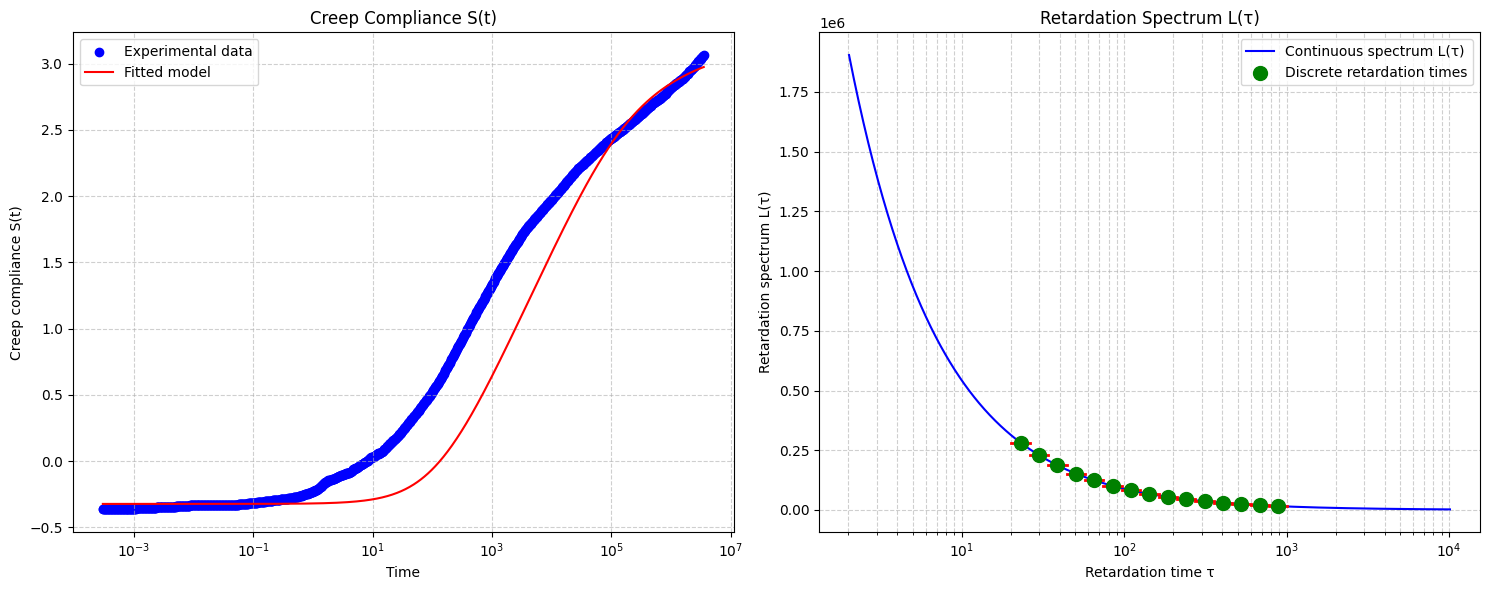

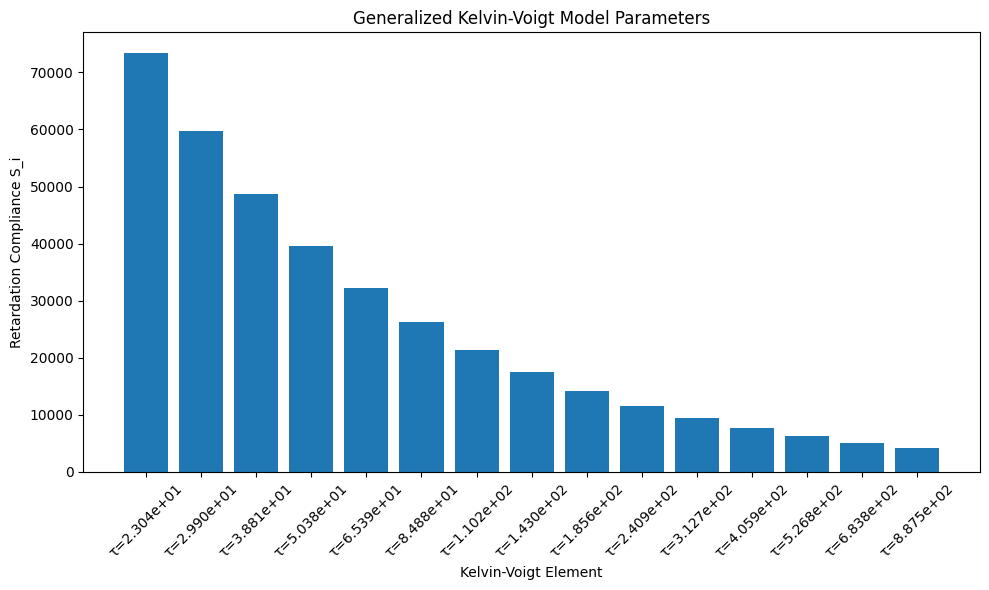

Mean squared error of discrete model: 65488960349.062485
Continuous Model Parameters:
  Sg: 0.4745605328067594
  S_inf: 1738.0657654304382
  beta: 0.21390731157414325
  t0: 94537.84312070753

Generalized Kelvin-Voigt Model Parameters:
  Element 1: S = 73352.073615, τ = 2.3039e+01
  Element 2: S = 59750.883652, τ = 2.9904e+01
  Element 3: S = 48670.619293, τ = 3.8814e+01
  Element 4: S = 39643.976974, τ = 5.0380e+01
  Element 5: S = 32290.273745, τ = 6.5392e+01
  Element 6: S = 26299.390877, τ = 8.4876e+01
  Element 7: S = 21418.693763, τ = 1.1017e+02
  Element 8: S = 17442.376410, τ = 1.4299e+02
  Element 9: S = 14202.781092, τ = 1.8560e+02
  Element 10: S = 11563.327050, τ = 2.4090e+02
  Element 11: S = 9412.749985, τ = 3.1269e+02
  Element 12: S = 7660.409379, τ = 4.0586e+02
  Element 13: S = 6232.465726, τ = 5.2679e+02
  Element 14: S = 5068.766439, τ = 6.8376e+02
  Element 15: S = 4120.309098, τ = 8.8750e+02

Residual R = 0.0603


In [23]:
def main():
    # Create instance of the class
    creep = CreepExperiments()
    
    # Either generate artificial data or load experimental data
    # times, compliance_values = generate_artificial_creep_data()
    
    # Uncomment to use your own experimental data
    # times, compliance_values = load_experimental_data('your_creep_data.csv')
    df = pd.read_csv("Filt_Se.csv", header=None)
    df.columns = ["log10(t)",  "log10(S_E_GPa)"]
    t_values = 10**df["log10(t)"].to_numpy()
    S_values = 10**df["log10(S_E_GPa)"].to_numpy()
    
    times, compliance_values = t_values, S_values
    
    # Process data and identify model parameters
    results = creep.process_experimental_data(times, compliance_values, n_elements=15)
    
    # Print results
    print("Continuous Model Parameters:")
    for key, value in results['continuous_model'].items():
        print(f"  {key}: {value}")
    
    print("\nGeneralized Kelvin-Voigt Model Parameters:")
    for i, (S, tau) in enumerate(zip(results['kelvin_voigt_model']['S_i'], results['kelvin_voigt_model']['tau_i'])):
        print(f"  Element {i+1}: S = {S:.6f}, τ = {tau:.4e}")
    
    print(f"\nResidual R = {results['residual']:.4f}")

if __name__ == "__main__":
    main()

Fitting model with 10 elements...
  MSE: 1.9080e-03, R²: 0.9986, BIC: -1141.1
Fitting model with 15 elements...
  MSE: 1.3098e-03, R²: 0.9990, BIC: -1163.3
Fitting model with 20 elements...
  MSE: 1.3022e-03, R²: 0.9991, BIC: -1111.5
Fitting model with 25 elements...
  MSE: 1.3403e-03, R²: 0.9990, BIC: -1052.8

Best model has 15 elements
MSE: 1.3098e-03, R²: 0.9990


/tmp/ipykernel_752225/2954647307.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


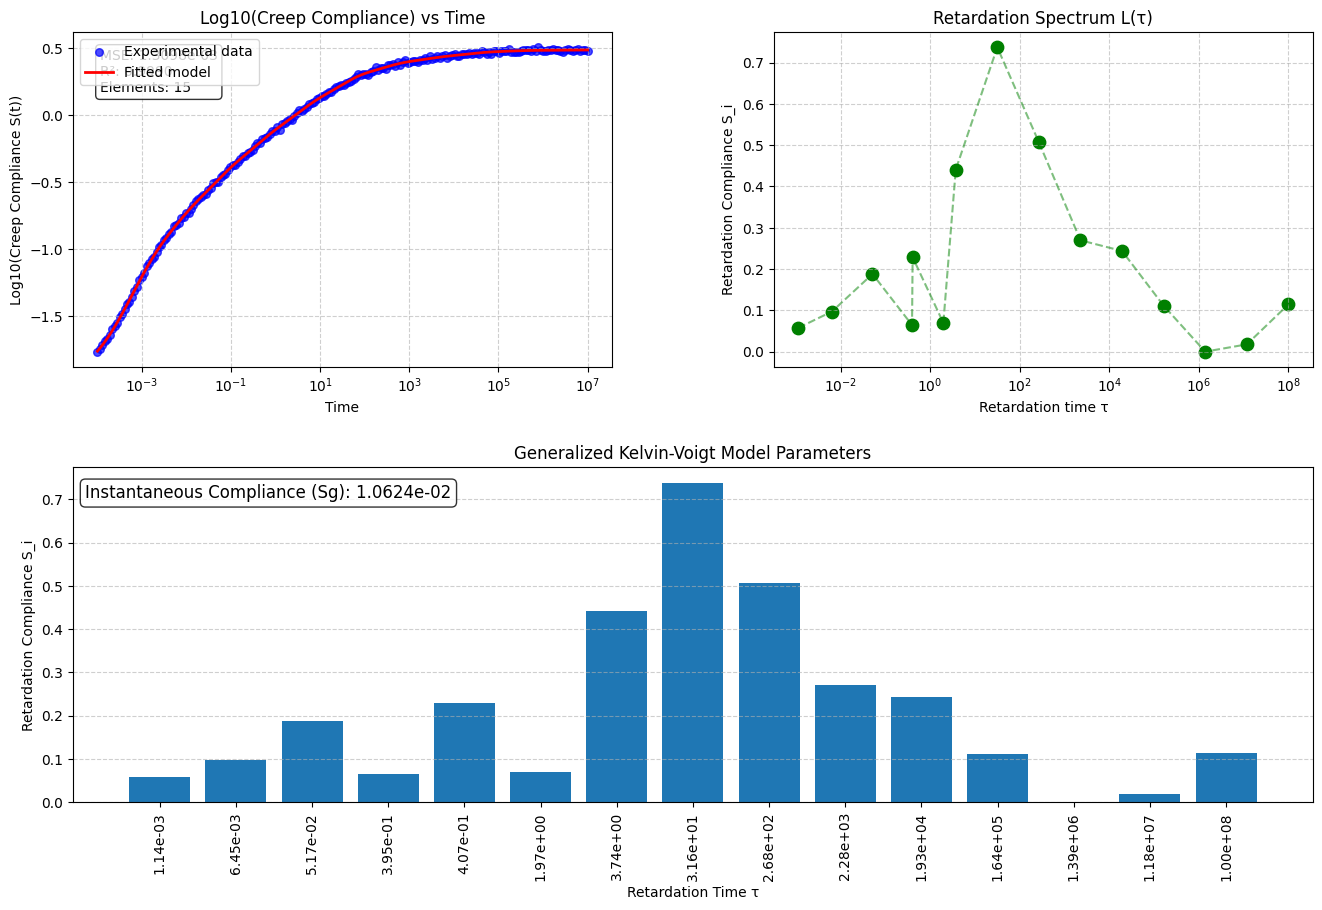


Generalized Kelvin-Voigt Model Parameters:
Sg = 1.062428e-02

Element    τ (s)           S_i
-----------------------------------
 1         1.138220e-03    5.760456e-02
 2         6.445535e-03    9.723524e-02
 3         5.167899e-02    1.880803e-01
 4         3.947163e-01    6.439040e-02
 5         4.068140e-01    2.287292e-01
 6         1.973316e+00    6.964391e-02
 7         3.739720e+00    4.409825e-01
 8         3.162377e+01    7.370448e-01
 9         2.682694e+02    5.071524e-01
10         2.275846e+03    2.697135e-01
11         1.930698e+04    2.438706e-01
12         1.637894e+05    1.112452e-01
13         1.389495e+06    0.000000e+00
14         1.178769e+07    1.769635e-02
15         1.000000e+08    1.144501e-01

MSE: 1.309761e-03
R²: 0.999049

Model ready for use in applications


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gamma
import pandas as pd

class MultiDecadeCreepModel:
    """
    Specialized implementation for identifying generalized Kelvin-Voigt model parameters
    from creep experiments data spanning multiple decades (master curve).
    """
    
    def __init__(self):
        self.Sg = None     # Instantaneous compliance
        self.S_inf = None  # Equilibrium (long-term) compliance
        self.n_elements = None  # Number of Kelvin-Voigt elements
        
    def creep_compliance_discrete(self, t, Sg, S_i, tau_i):
        """
        Calculate the creep compliance S(t) using the generalized Kelvin-Voigt model:
        
        S(t) = Sg + sum_i^N S_i * (1 - exp(-t/tau_i))
        
        Parameters:
        - t: time points
        - Sg: Instantaneous compliance
        - S_i: Array of retardation compliances
        - tau_i: Array of retardation times
        
        Returns:
        - S(t): Creep compliance values
        """
        compliance = np.zeros_like(t, dtype=float)
        compliance += Sg  # Add instantaneous compliance
        
        # Add contribution from each Kelvin-Voigt element
        for i in range(len(S_i)):
            compliance += S_i[i] * (1 - np.exp(-t/tau_i[i]))
            
        return compliance
    
    def fit_direct_discrete_model(self, times, compliance_values, n_elements):
        """
        Directly fit a discrete generalized Kelvin-Voigt model optimized for
        multi-decade data spans (master curves).
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        - n_elements: Number of Kelvin-Voigt elements
        
        Returns:
        - params: Dictionary with fitted parameters
        """
        # Place retardation times logarithmically distributed across the entire time range
        # For master curves, we need more density of elements
        tau_i_init = np.logspace(
            np.log10(min(times) * 0.1),  # Go slightly below min time
            np.log10(max(times) * 10),    # Go slightly above max time
            n_elements
        )
        
        # Initial guess for Sg (the starting compliance)
        Sg_init = min(compliance_values)
        
        # For multi-decade data, calculate better initial S_i values
        # Sort data by time
        sort_idx = np.argsort(times)
        sorted_times = times[sort_idx]
        sorted_compliance = compliance_values[sort_idx]
        
        # Calculate total change in compliance
        total_delta_S = max(compliance_values) - min(compliance_values)
        
        # Distribute S_i proportionally across logarithmic time bins
        S_i_init = np.zeros(n_elements)
        log_time_bins = np.logspace(np.log10(min(times)), np.log10(max(times)), n_elements+1)
        
        for i in range(n_elements):
            # Find data points in this bin
            bin_mask = (sorted_times >= log_time_bins[i]) & (sorted_times < log_time_bins[i+1])
            if np.sum(bin_mask) > 0:
                # If data exists in this bin, calculate compliance change
                bin_delta = np.max(sorted_compliance[bin_mask]) - np.min(sorted_compliance[bin_mask])
                S_i_init[i] = max(bin_delta, total_delta_S / n_elements * 0.5)
            else:
                # Default value if no data in this bin
                S_i_init[i] = total_delta_S / n_elements * 0.5
        
        # Combine parameters
        initial_params = np.concatenate(([Sg_init], S_i_init, tau_i_init))
        
        # Define objective function for fitting in log space (better for multi-decade data)
        def objective(params):
            Sg = params[0]
            S_i = params[1:n_elements+1]
            tau_i = params[n_elements+1:]
            
            # Ensure all tau values are positive
            if np.any(tau_i <= 0):
                return 1e10
                
            # Calculate model prediction
            predicted = self.creep_compliance_discrete(times, Sg, S_i, tau_i)
            
            # For multi-decade data, weighting by log is more appropriate
            # This gives equal importance to all decades
            log_ratio = np.log10(predicted / compliance_values)
            # Replace any infinite values with a large number
            log_ratio = np.nan_to_num(log_ratio, nan=10, posinf=10, neginf=-10)
            
            # Calculate weighted error (equally weighted across log decades)
            error = np.sum(log_ratio**2)
            
            return error
        
        # Parameter bounds
        bounds = [(min(compliance_values)*0.5, min(compliance_values)*1.5)]  # Sg bounds
        bounds.extend([(0, max(compliance_values)) for _ in range(n_elements)])  # S_i bounds (all positive)
        bounds.extend([(min(times)*0.01, max(times)*100) for _ in range(n_elements)])  # tau_i bounds
        
        # Perform optimization
        result = minimize(
            objective, 
            initial_params, 
            bounds=bounds, 
            method='L-BFGS-B',
            options={'maxiter': 10000, 'maxfun': 50000}
        )
        
        # Extract fitted parameters
        Sg = result.x[0]
        S_i = result.x[1:n_elements+1]
        tau_i = result.x[n_elements+1:]
        
        # Sort elements by increasing tau_i
        idx = np.argsort(tau_i)
        tau_i = tau_i[idx]
        S_i = S_i[idx]
        
        # Calculate regular error (not log-weighted) for reporting
        predicted = self.creep_compliance_discrete(times, Sg, S_i, tau_i)
        mse = np.mean((predicted - compliance_values)**2)
        
        # Calculate R² value
        ss_total = np.sum((compliance_values - np.mean(compliance_values))**2)
        ss_residual = np.sum((compliance_values - predicted)**2)
        r_squared = 1 - (ss_residual / ss_total)
        
        # Store class attributes
        self.Sg = Sg
        self.n_elements = n_elements
        
        return {
            'Sg': Sg,
            'S_i': S_i,
            'tau_i': tau_i,
            'mse': mse,
            'r_squared': r_squared
        }
    
    def fit_multi_element_model(self, times, compliance_values, n_elements_list=[10, 15, 20, 25]):
        """
        Try fitting with different numbers of elements and choose the best one
        based on a balance of fit quality and model complexity.
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        - n_elements_list: List of element counts to try
        
        Returns:
        - best_result: Dictionary with best model parameters and metrics
        """
        results = []
        
        for n_elements in n_elements_list:
            print(f"Fitting model with {n_elements} elements...")
            try:
                result = self.fit_direct_discrete_model(times, compliance_values, n_elements)
                result['n_elements'] = n_elements
                
                # Calculate BIC (Bayesian Information Criterion) for model selection
                n_params = 1 + 2 * n_elements  # Sg + n_elements*(S_i + tau_i)
                n_data = len(times)
                log_likelihood = -n_data/2 * np.log(result['mse'])  # Approximation
                bic = np.log(n_data) * n_params - 2 * log_likelihood
                
                result['bic'] = bic
                results.append(result)
                
                print(f"  MSE: {result['mse']:.4e}, R²: {result['r_squared']:.4f}, BIC: {bic:.1f}")
            except Exception as e:
                print(f"  Failed: {str(e)}")
        
        if not results:
            raise ValueError("All model fitting attempts failed.")
        
        # Select best model based on BIC (lower is better)
        best_result = min(results, key=lambda x: x['bic'])
        
        print(f"\nBest model has {best_result['n_elements']} elements")
        print(f"MSE: {best_result['mse']:.4e}, R²: {best_result['r_squared']:.4f}")
        
        return best_result
    
    def plot_results(self, times, compliance_values, model_params, plot_log_compliance=True):
        """
        Plot results with either regular or log scale for compliance
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        - model_params: Fitted model parameters
        - plot_log_compliance: Whether to plot log10(compliance) instead of compliance
        """
        # Calculate model prediction
        Sg = model_params['Sg']
        S_i = model_params['S_i']
        tau_i = model_params['tau_i']
        
        # Generate smooth time points for plotting
        plot_times = np.logspace(np.log10(min(times)), np.log10(max(times)), 1000)
        predicted = self.creep_compliance_discrete(plot_times, Sg, S_i, tau_i)
        
        # Also calculate predictions at the exact data points for error metrics
        data_predicted = self.creep_compliance_discrete(times, Sg, S_i, tau_i)
        
        # Create figure with 3 subplots: 
        # 1. Compliance vs Time
        # 2. Retardation Spectrum
        # 3. Model Elements
        fig = plt.figure(figsize=(16, 10))
        grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.3)
        
        # Plot 1: Compliance vs Time (with either normal or log compliance)
        ax1 = fig.add_subplot(grid[0, 0])
        
        if plot_log_compliance:
            # Convert to log10 for both data and prediction
            # Handle any zero or negative values 
            min_positive = np.min(compliance_values[compliance_values > 0])
            safe_compliance = np.maximum(compliance_values, min_positive * 0.1)
            safe_predicted = np.maximum(predicted, min_positive * 0.1)
            safe_data_predicted = np.maximum(data_predicted, min_positive * 0.1)
            
            ax1.scatter(times, np.log10(safe_compliance), s=30, alpha=0.7, label='Experimental data', color='blue')
            ax1.plot(plot_times, np.log10(safe_predicted), 'r-', linewidth=2, label='Fitted model')
            
            ax1.set_ylabel('Log10(Creep Compliance S(t))')
            title = 'Log10(Creep Compliance) vs Time'
        else:
            ax1.scatter(times, compliance_values, s=30, alpha=0.7, label='Experimental data', color='blue')
            ax1.plot(plot_times, predicted, 'r-', linewidth=2, label='Fitted model')
            
            ax1.set_ylabel('Creep Compliance S(t)')
            title = 'Creep Compliance vs Time'
        
        ax1.set_xscale('log')
        ax1.set_xlabel('Time')
        ax1.set_title(title)
        ax1.legend()
        ax1.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Add metrics as text
        mse = model_params['mse']
        r2 = model_params['r_squared']
        n_elements = model_params['n_elements']
        
        ax1.text(0.05, 0.95, f"MSE: {mse:.4e}\nR²: {r2:.4f}\nElements: {n_elements}", 
                transform=ax1.transAxes, fontsize=10, va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot 2: Retardation Spectrum (S_i vs tau_i)
        ax2 = fig.add_subplot(grid[0, 1])
        
        # Draw discrete spectrum points
        ax2.scatter(tau_i, S_i, s=80, c='green', marker='o', label='Discrete retardation times')
        
        # Connect with line for visualization
        sort_idx = np.argsort(tau_i)
        ax2.plot(tau_i[sort_idx], S_i[sort_idx], 'g--', alpha=0.5)
        
        ax2.set_xscale('log')
        ax2.set_xlabel('Retardation time τ')
        ax2.set_ylabel('Retardation Compliance S_i')
        ax2.set_title('Retardation Spectrum L(τ)')
        ax2.grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Plot 3: Bar chart of Kelvin-Voigt elements
        ax3 = fig.add_subplot(grid[1, :])
        
        # Scale x position logarithmically for better visualization
        width = 0.8
        x_pos = np.arange(len(tau_i))
        
        # Create bar chart with tau values on x-axis
        bars = ax3.bar(x_pos, S_i, width, label='S_i')
        
        # Set x-ticks to tau values (formatted with scientific notation)
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels([f"{t:.2e}" for t in tau_i], rotation=90)
        
        ax3.set_xlabel('Retardation Time τ')
        ax3.set_ylabel('Retardation Compliance S_i')
        ax3.set_title('Generalized Kelvin-Voigt Model Parameters')
        ax3.grid(True, axis='y', linestyle='--', alpha=0.6)
        
        # Add instantaneous compliance value as text
        ax3.text(0.01, 0.95, f"Instantaneous Compliance (Sg): {Sg:.4e}",
                transform=ax3.transAxes, fontsize=12, va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Return the figure for saving if needed
        return fig
    
    def process_master_curve_data(self, times, compliance_values, n_elements=15, plot_log=True):
        """
        Process master curve data spanning multiple decades
        
        Parameters:
        - times: Experimental time points
        - compliance_values: Experimental creep compliance values
        - n_elements: Number of Kelvin-Voigt elements or list of values to try
        - plot_log: Whether to plot log10(compliance) instead of compliance
        
        Returns:
        - results: Dictionary with model parameters and metrics
        """
        # Check if n_elements is a single value or a list
        if isinstance(n_elements, list):
            # Try multiple element counts
            result = self.fit_multi_element_model(times, compliance_values, n_elements)
        else:
            # Use specified number of elements
            result = self.fit_direct_discrete_model(times, compliance_values, n_elements)
            result['n_elements'] = n_elements
        
        # Plot results
        fig = self.plot_results(times, compliance_values, result, plot_log_compliance=plot_log)
        
        # Print model parameters in a tabular format
        print("\nGeneralized Kelvin-Voigt Model Parameters:")
        print(f"Sg = {result['Sg']:.6e}")
        print("\nElement    τ (s)           S_i")
        print("-" * 35)
        
        for i, (tau, s) in enumerate(zip(result['tau_i'], result['S_i'])):
            print(f"{i+1:2d}         {tau:.6e}    {s:.6e}")
        
        print(f"\nMSE: {result['mse']:.6e}")
        print(f"R²: {result['r_squared']:.6f}")
        
        return {
            'model_params': result,
            'figure': fig
        }


# Function to load experimental data from CSV
def load_experimental_data(file_path):
    """
    Load experimental data from CSV file
    Expected format: two columns (time, compliance)
    """
    data = pd.read_csv(file_path)
    times = data.iloc[:, 0].values
    compliance_values = data.iloc[:, 1].values
    return times, compliance_values

# Example usage with master curve data
def main():
    # Create instance of the specialized class
    model = MultiDecadeCreepModel()
    
    # Load your experimental data
    # times, compliance_values = load_experimental_data("your_master_curve.csv")
    
    # For demonstration with synthetic data spanning multiple decades:
    times = np.logspace(-4, 7, 200)  # From 10^-4 to 10^7
    
    # Create synthetic compliance data with multi-decade behavior
    Sg = 1e-2
    compliance_values = np.zeros_like(times)
    
    # Define multiple Kelvin-Voigt elements across time scales
    tau_values = np.logspace(-3, 6, 15)  # 15 elements across 9 decades
    S_values = np.array([
        5e-2, 7e-2, 1e-1, 1.5e-1, 2e-1, 
        3e-1, 4e-1, 5e-1, 4e-1, 3e-1, 
        2e-1, 1.5e-1, 1e-1, 7e-2, 5e-2
    ])
    
    # Calculate compliance
    compliance_values = np.ones_like(times) * Sg
    for tau, S in zip(tau_values, S_values):
        compliance_values += S * (1 - np.exp(-times/tau))
    
    # Add some noise (proportional to the value, common in log-scale data)
    np.random.seed(42)
    rel_noise = 0.02  # 2% relative noise
    noise = rel_noise * compliance_values * np.random.randn(len(times))
    compliance_values += noise
    
    # Process the data
    # Try with different numbers of elements (you can specify a single value too)
    results = model.process_master_curve_data(
        times, 
        compliance_values, 
        n_elements=[10, 15, 20, 25], 
        plot_log=True
    )
    
    # Access the results
    model_params = results['model_params']
    fig = results['figure']
    
    # You could save the figure
    # fig.savefig("master_curve_fit.png", dpi=300, bbox_inches='tight')
    
    # Extract model parameters for your own use
    Sg = model_params['Sg']
    S_i = model_params['S_i']
    tau_i = model_params['tau_i']
    
    # These parameters can be used directly in your applications
    print("\nModel ready for use in applications")

if __name__ == "__main__":
    main()

Fitting model with 5 elements...
  MSE: 1.5153e+04, R²: 0.8958, BIC: 4012.8
Fitting model with 6 elements...
  MSE: 9.7197e+03, R²: 0.9331, BIC: 3842.8
Fitting model with 7 elements...
  MSE: 5.2496e+03, R²: 0.9639, BIC: 3602.3
Fitting model with 8 elements...
  MSE: 2.1415e+03, R²: 0.9853, BIC: 3246.7
Fitting model with 9 elements...
  MSE: 8.5699e+02, R²: 0.9941, BIC: 2883.2
Fitting model with 10 elements...
  MSE: 3.9850e+02, R²: 0.9973, BIC: 2581.3
Fitting model with 15 elements...
  MSE: 8.5843e+02, R²: 0.9941, BIC: 2956.1
Fitting model with 20 elements...
  MSE: 2.3361e+02, R²: 0.9984, BIC: 2482.7

Best model has 20 elements
MSE: 2.3361e+02, R²: 0.9984


/tmp/ipykernel_752225/2954647307.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


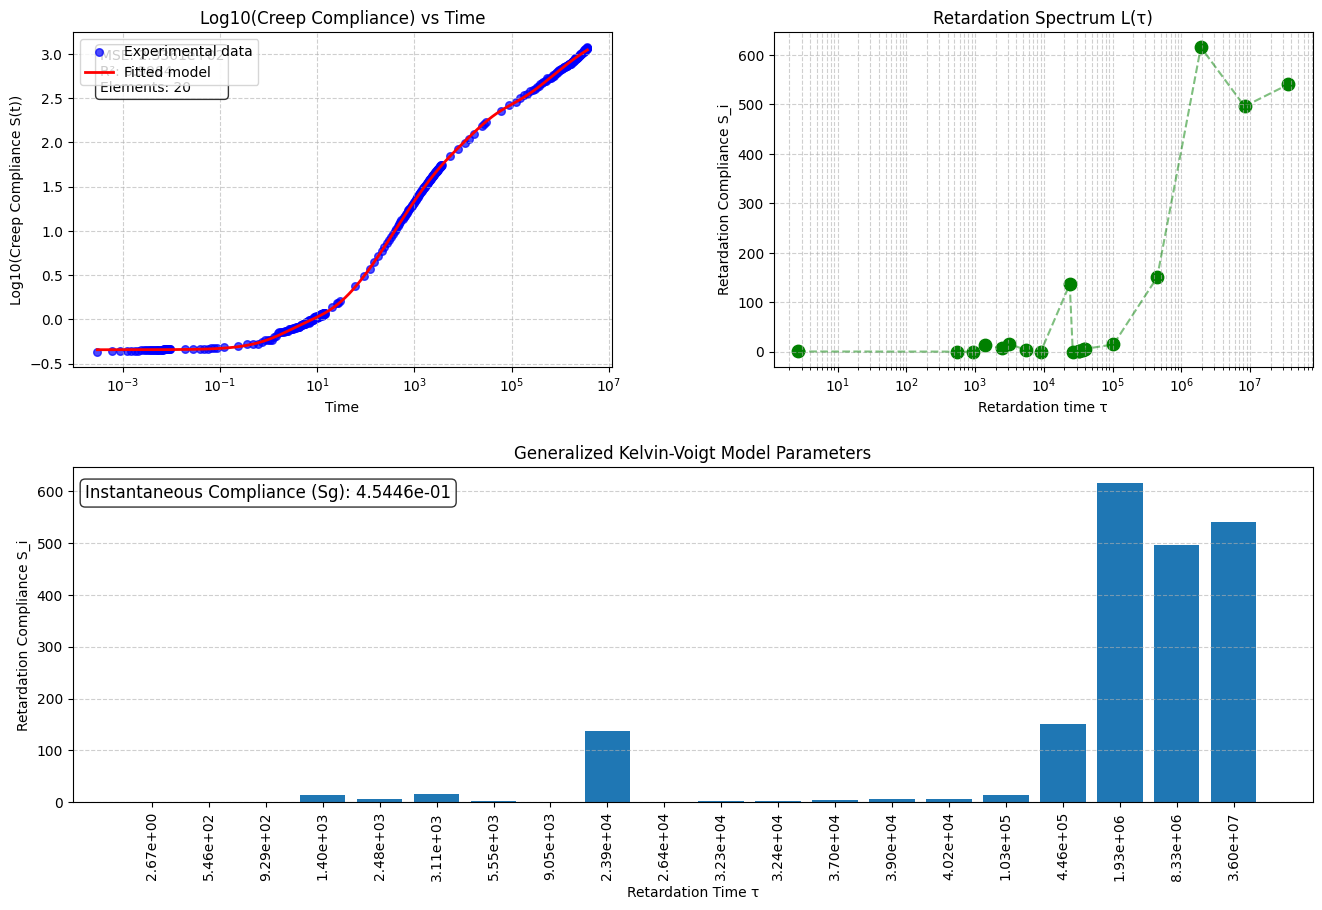


Generalized Kelvin-Voigt Model Parameters:
Sg = 4.544638e-01

Element    τ (s)           S_i
-----------------------------------
 1         2.673170e+00    3.678768e-01
 2         5.456976e+02    9.748158e-02
 3         9.291300e+02    0.000000e+00
 4         1.403496e+03    1.316870e+01
 5         2.477846e+03    6.811654e+00
 6         3.112465e+03    1.648018e+01
 7         5.545047e+03    2.757650e+00
 8         9.051170e+03    0.000000e+00
 9         2.385812e+04    1.364497e+02
10         2.640572e+04    0.000000e+00
11         3.225032e+04    1.215305e+00
12         3.235184e+04    1.283559e+00
13         3.701627e+04    4.088615e+00
14         3.902593e+04    5.126269e+00
15         4.023833e+04    5.707874e+00
16         1.031144e+05    1.460223e+01
17         4.457214e+05    1.503634e+02
18         1.926681e+06    6.156617e+02
19         8.328295e+06    4.962994e+02
20         3.600000e+07    5.405676e+02

MSE: 2.336059e+02
R²: 0.998393

Model ready for use in applications


In [33]:
def main():
    # Create instance of the specialized class
    model = MultiDecadeCreepModel()
    
    # Load your experimental data
    # times, compliance_values = load_experimental_data("CM_Creep.csv")
    # df = pd.read_csv("Filt_Se.csv", header=None)
    # df.columns = ["log10(t)",  "log10(S_E_GPa)"]
    # t_values = 10**df["log10(t)"].to_numpy()
    # S_values = 10**df["log10(S_E_GPa)"].to_numpy()

    df= pd.read_csv("CM_Creep.csv")
    df["t"] = 10**df["log10(t)"]
    df["S_E"] = 10**df["log10(S_E)"]
    df["S_E_GPa"] = df.S_E * 1e9
    t_values = 10**df["log10(t)"].to_numpy()
    S_values =df["S_E_GPa"].to_numpy() 

    times, compliance_values = t_values, S_values
    
    
    # times, compliance_values = t_values, S_values
       
    # Process the data
    # Try with different numbers of elements (you can specify a single value too)
    results = model.process_master_curve_data(
        times, 
        compliance_values, 
        #n_elements=[10, 15, 20, 25], 
        n_elements=[5,6,7,8,9,10,15,20],
        plot_log=True
    )
    
    # Access the results
    model_params = results['model_params']
    fig = results['figure']
    
    # You could save the figure
    # fig.savefig("master_curve_fit.png", dpi=300, bbox_inches='tight')
    
    # Extract model parameters for your own use
    Sg = model_params['Sg']
    S_i = model_params['S_i']
    tau_i = model_params['tau_i']
    
    # These parameters can be used directly in your applications
    print("\nModel ready for use in applications")

if __name__ == "__main__":
    main()